#### passing shuffled images to a simple CNN network for classification using <br> cross entropy as loss, a shuffled image's tile are seperately passed to different channels

In [3]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
image_dir = "D:\sem6\DL\cavallo"

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)
    
    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


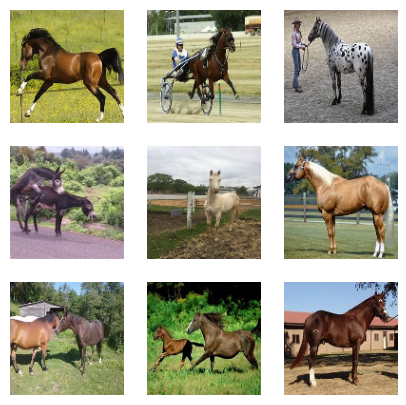

In [7]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [8]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts

In [9]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [10]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [11]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)
    
    for idx, combination in enumerate(combinations):

        # shape of combination is (9, 40, 40, 3)
        combination = np.array(combination).transpose(0, 3, 1, 2)
        combination = np.concatenate(combination, axis=0).transpose(1, 2, 0)
        input_data.append(combination)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [12]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 40, 40, 27)
Target data shape: (26230, 81)


In [13]:
# select random image
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])

target
[[0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0]]
non_converted_target [1, 2, 3, 5, 8, 6, 0, 7, 4]


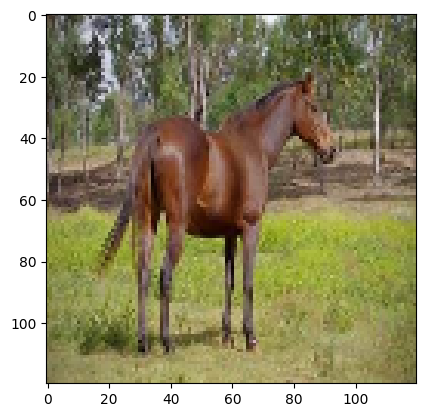

In [14]:
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data, test=False):
    
    sequenced = [0] * 9
    for i in range(0,27,3):

        # stack the 3 channels to get the original image
        blue_channel = img[:,:,i]
        green_channel = img[:,:,i+1]
        red_channel = img[:,:,i+2]

        # stack the 3 channels to get the original image
        tile = np.stack((blue_channel, green_channel, red_channel), axis=2)

        if test:
            sequenced[i // 3] = tile
        else:
            sequenced[non_converted_target_data[i // 3]] = tile

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img


reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [15]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [16]:
class JigsawModel(nn.Module):
    def __init__(self):
        super(JigsawModel, self).__init__()
        self.conv1 = nn.Conv2d(27, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 10, 4096)
        #self.fc1 = nn.Linear(128 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512) 
        self.fc4 = nn.Linear(512, 81)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 128 * 10 * 10)
        #x = x.reshape(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [17]:
model = JigsawModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10
batch_size = 64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [19]:
# test_dataset = JigsawDataset(X_test, y_test)

# # Convert to NumPy array using a method in the class (if available)
# dataset_array = test_dataset.to_numpy()

# # Save the array to a .npy file
# np.save('test_dataset.npy', dataset_array)
# dataset_pkl = test_dataset.to_pickle()
# np.save('test_dataset.pkl', dataset_pkl)

In [20]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # cnn input shape is (batch_size, channels, height, width)
        inputs = inputs.permute(0, 3, 1, 2).float()
        optimizer.zero_grad()
        
        outputs = model(inputs)      
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

In [21]:
# import os

# # Get the current working directory
# current_directory = os.getcwd()
# print("Current Directory:", current_directory)

# # Optionally, change the working directory

# print("Directory changed to:", os.getcwd())

# # Save the model in the new directory
# torch.save(model.state_dict(), 'correctedmodel.pth')

# print('Model saved to', os.path.join(os.getcwd(), 'model.pth'))

In [22]:
def recur(sequence, outputs):
    sequence = np.array(sequence)
    for i in range(len(sequence)):
        while np.sum(sequence == sequence[i]) > 1:  # If the current element is a duplicate
            # Find the index in outputs for the current sequence element that is not yet in the updated sequence
            scores = outputs[i]
            sorted_indices = np.argsort(scores)[::-1]  # Indices of scores sorted in descending order
            for idx in sorted_indices:
                if idx not in sequence:
                    sequence[i] = idx
                    break
                
    return sequence.tolist()

In [23]:
# correct = 0
# total = 0
# per_tile_accuracy = 0

# model.eval()
# with torch.no_grad():
#     for data in test_loader:
#         inputs, labels = data
#         inputs = inputs.permute(0, 3, 1, 2).float()
#         outputs = model(inputs)

#         # reshape the output to 9x9 matrix
#         outputs = outputs.reshape(-1, 9, 9)
#         predicted = torch.argmax(outputs, dim=1)

#         # now doing the same for the target
#         labels = labels.reshape(-1, 9, 9)
#         target = torch.argmax(labels, dim=1)

#         # check if the predicted sequence is correct
#         for i in range(len(predicted)):
#             updated_predicted = recur(predicted[i], outputs[i, : , :].numpy())
            
#             if torch.equal(torch.tensor(updated_predicted), target[i]):
#                 correct += 1
#             total += 1

#             per_tile_accuracy += (np.array(updated_predicted) == target[i].numpy()).sum() / 9

# print('Accuracy on test images: %d %%' % (100 * correct / total))
# print('Per tile accuracy on test images: %d %%' % (100 * per_tile_accuracy / total))

In [ ]:
# select random image from test set
idx = random.randint(0, len(X_test))
image = X_test[idx]
target = y_test[idx]


plt.figure(figsize=(10, 10))
converted_target = np.argmax(target.reshape(9, 9), axis=1)

plt.subplot(131)
plt.imshow(cv2.cvtColor(reconstructed_image(image, converted_target, test=True), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
print("target", target.reshape(9, 9), sep="\n")
print("converted target", converted_target, sep="\n")
reconstructed_img = reconstructed_image(image, converted_target)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with target sequence')
                 
plt.subplot(133)
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
outputs = model(inputs)
outputs = outputs.reshape(9, 9)
print("outputs", outputs, sep="\n")

predicted = torch.argmax(outputs, dim=1)
print("predicted", predicted, sep="\n")
updated_predicted = recur(predicted, outputs.detach().numpy())
print("updated predicted", updated_predicted, sep="\n")

reconstructed_img = reconstructed_image(image, updated_predicted)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with predicted sequence')

In [ ]:
model = JigsawModel()
model.load_state_dict(torch.load('cnn_ann_model.pth'))
model.eval()
# Set the model to evaluation mode


JigsawModel(
  (conv1): Conv2d(27, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=81, bias=True)
)

In [ ]:
idx = random.randint(0, len(X_test))
image = X_test[idx]
target = y_test[idx]
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
outputs = model(inputs)
outputs = outputs.reshape(9, 9)
print(outputs)
converted_target = np.argmax(target.reshape(9, 9), axis=1)
print(converted_target)

In [ ]:

def process_image(image, model):
    inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    outputs = model(inputs)
    outputs = outputs.reshape(9, 9)
    return outputs

def fix_max_positions(outputs, fixed_positions):
    for i in range(outputs.shape[0]):
        max_index = outputs[i].argmax()
        fixed_positions[i, max_index] = True
    return fixed_positions

def iterative_solve(model, X_test, y_test, i,num_iterations=9):
    idx = i
    image = X_test[idx]
    target = y_test[idx]
    outputs = process_image(image, model)
    print("Initial outputs:")
    print(outputs)

    fixed_positions = np.zeros(outputs.shape, dtype=bool)
    converted_outputs = np.zeros_like(outputs.detach().numpy())  # Modify this line

    for i in range(num_iterations):
        fixed_positions = fix_max_positions(outputs, fixed_positions)
        outputs = process_image(image, model)  # Assuming re-evaluation with fixed positions
        converted_outputs = np.argmax(outputs.detach().numpy(), axis=1)  # Detach before converting

    # Final converted outputs
    final_converted_outputs = np.argmax(outputs.detach().numpy(), axis=1)  # Detach before converting
    converted_target = np.argmax(target.reshape(9, 9), axis=1)
    print(converted_target)

    # Calculate accuracy or comparison metric if desired
    accuracy = np.mean(final_converted_outputs == converted_target)
    #print(f"Accuracy: {accuracy*100:.2f}%")
    return accuracy
l = []
for i in range(len(X_test)):
    accuracy1 = iterative_solve(model, X_test, y_test, i,num_iterations=9)
    l.append(accuracy1)
print(np.mean(l))



In [ ]:
# import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

# Sample tensor output from your model
logits = torch.tensor([[ 2.3782,  1.3637, -0.4413,  0.5571, -2.0462,  0.4586, -0.9831,  1.1946, 0.1377],
                       [ 1.8238,  1.7925,  2.0295,  1.1280, -1.3376, -0.1343, -1.2750, -2.7792, -1.7438],
                       [ 1.8847,  2.3111,  0.5000, -1.2877, -3.2267, -0.0140,  0.8278,  0.0724, 0.8302],
                       [-0.0981, -2.2014, -0.8123,  1.1570, -0.7898, -0.1121,  3.0562,  1.2854, 0.9707],
                       [-2.3844, -0.0529, -1.3790,  1.8561,  0.9242, -0.6280,  3.6171,  2.5855, 1.3122],
                       [-0.3859, -2.9752, -1.6588,  0.7147,  2.6847, -1.5414, -0.2093,  1.2233, -0.8501],
                       [ 0.1755,  3.4025,  4.1595, -1.4491, -1.7863,  0.2514, -1.9663, -1.7259, -1.4857],
                       [-2.2308, -0.5360, -0.1002,  0.3066,  3.1011,  1.4230, -0.4463, -1.1392, -2.4572],
                       [-1.3142, -2.4695, -2.2635, -0.0331, -1.0481,  1.5937,  1.0164,  2.5805, 3.1546]])

# Convert logits to costs
cost_matrix = -logits.numpy()

# Apply the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create a new tensor to store the assigned classes
assigned_classes = torch.zeros_like(logits)
for i, j in zip(row_ind, col_ind):
    assigned_classes[i, j] = 1

print("Assignment Matrix:")
print(assigned_classes)


Assignment Matrix:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [ ]:
import torch
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Assuming you already have these defined somewhere:
# model: your trained model
# X_test, y_test: your test datasets
# reconstructed_image: function to reconstruct image based on predictions

# Select a random image from the test set
idx = random.randint(0, len(X_test))
image = X_test[idx]
target = y_test[idx]

plt.figure(figsize=(30, 10))

# Plot original image
converted_target = np.argmax(target.reshape(9, 9), axis=1)
plt.subplot(131)
plt.imshow(cv2.cvtColor(reconstructed_image(image, converted_target, test=True), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Print target for debugging
print("target", target.reshape(9, 9), sep="\n")
print("converted target", converted_target, sep="\n")

# Plot image with target sequence
reconstructed_img = reconstructed_image(image, converted_target)
plt.subplot(132)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('With Target Sequence')

# Get model outputs
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
outputs = model(inputs)
outputs = outputs.reshape(9, 9)
#print("outputs", outputs, sep="\n")

# Hungarian algorithm to find the best assignment
cost_matrix = -outputs.detach().numpy()  # Converting logits to costs
row_ind, col_ind = linear_sum_assignment(cost_matrix)
predicted = col_ind

print("predicted (original indices)", predicted, sep="\n")

# Plot image with predicted sequence using Hungarian algorithm
reconstructed_img = reconstructed_image(image, predicted)
plt.subplot(133)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('With Predicted Sequence')

plt.show()


In [36]:
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

def process_image(image, model):
    inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    outputs = model(inputs)
    outputs = outputs.reshape(9, 9)
    return outputs

def apply_hungarian_algorithm(outputs):
    # Convert logits to costs for the Hungarian algorithm
    costs = -outputs.detach().numpy()
    row_ind, col_ind = linear_sum_assignment(costs)
    return row_ind, col_ind

def iterative_solve(model, X_test, y_test, idx, num_iterations=9):
    image = X_test[idx]
    target = y_test[idx]

    for _ in range(num_iterations):
        outputs = process_image(image, model)
        row_ind, col_ind = apply_hungarian_algorithm(outputs)

        # Debug prints to see outputs and the indices after applying Hungarian algorithm
        print("Iteration outputs:")
        print(outputs)
        print("Row indices:", row_ind)
        print("Column indices:", col_ind)

        # If required, modify the model inputs here based on the new assignments

    # Get the final outputs after all iterations
    final_outputs = process_image(image, model)
    row_ind, col_ind = apply_hungarian_algorithm(final_outputs)
    
    # Get final predictions
    final_predictions = col_ind

    # Get target in similar format for comparison
    converted_target = np.argmax(target.reshape(9, 9), axis=1)

    print("Final converted outputs:", final_predictions)
    print("Converted target:", converted_target)

    # Visualization or further processing can be done here


In [ ]:
def hungarian_loss(outputs, labels):
    batch_size = outputs.size(0)
    n = outputs.size(1)

    # Reshape outputs and labels to 2D matrices
    outputs = outputs.view(batch_size, -1)
    labels = labels.view(batch_size, -1)

    # Calculate pairwise distance
    dist = torch.cdist(outputs, labels, p=2)

    # Solve the assignment problem using the Hungarian algorithm
    cost_matrix = dist.cpu().detach().numpy()
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Compute the Hungarian loss
    loss = torch.tensor(cost_matrix[row_ind, col_ind].sum() / batch_size)

    return loss.to(outputs.device)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class JigsawModel(nn.Module):
    def __init__(self):
        super(JigsawModel, self).__init__()
        self.conv1 = nn.Conv2d(27, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 81)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1, 9, 9)
        return x

def solve_jigsaw(model, input_features):
    num_positions = 9 * 9  # Total 81 positions
    fixed_positions = np.zeros((9, 9), dtype=bool)
    scores = torch.zeros((9, 9))

    for _ in range(num_positions):
        with torch.no_grad():
            output = model(input_features)
        
        output = output.view(-1, 9, 9)
        
        # Apply mask to fixed positions by setting their scores very low
        output[fixed_positions] = -1e6
        
        # Find the position with the maximum score
        max_pos = torch.argmax(output).item()
        row, col = divmod(max_pos, 9)
        
        # Fix the position with the highest score
        fixed_positions[row, col] = True
        
        # Optionally, update the input features based on fixed positions
        # This depends on how your model interacts with fixed pieces
        
        # Update the scores for visualizing or further processing
        scores[row, col] = output[row, col]

    return scores

# Assuming model is initialized and input_features are prepared
model = JigsawModel()
input_features = torch.randn(1, 27, 32, 32)  # Example input tensor
final_scores = solve_jigsaw(model, input_features)
print("Final placement scores:", final_scores)
